# PPO
## from on-policy to off-policy
on-policy vs off-policy：
* on-policy:训练的agent同时学习和与环境进行互动，在训练过程中，PG之前，agent需要先与环境进行一系列episode，获取多个$\tau$，然后利用这些$\tau$进行参数更新，但这一系列的episode只能用一次，下一次训练就需要重新与环境交互。  
* off-policy：一个agent进行学习，另一个agent负责与环境交互，在这个过程中，与环境交互的agent获得一系列episode后，学习的agent可以利用这些$\tau$进行多次的参数更新，相比较on-policy而言，减少了数据收集的过程。  
 
on-policy训练梯度：$\nabla \overline{R}_{\theta} = E_{\tau \sim p_{\theta}(\tau)}[R(\tau) \nabla logp_{\theta}(\tau)]$  
首先利用策略$\pi_{\theta}$收集数据，然后根据数据更新参数$\theta$，由于更新了参数，所以之前利用原先参数收集的数据就不能再用了，需要重新收集数据，这样数据收集耗时比较就。  
我们希望存在一个策略$\pi_{\theta^{'}}$来收集数据，用这些数据来训练$\theta$，这样我们可以重复使用收集的数据。  
## Importance Sampling
$E_{x \sim p}[f(x)] \approx \frac{1}{N} \sum_{i=1}^Nf(x^i)$
计算此时f(x)的期望，我们需要利用分布p(x)来抽取数据$x^i$，但我们没有这些数据样本，我们只有利用分布q(x)抽取的数据样本$x^i$。
$\begin{equation}
\begin{aligned}
E_{x \sim p}[f(x)] &= \int f(x)p(x)dx \\
&=\int f(x) \frac{p(x)}{q(x)}q(x)dx \\
&=E_{x \sim q}[f(x)\frac{p(x)}{q(x)}]
\end{aligned}
\end{equation}$  
通过这样子的转换，我们可以使用分布q对数据进行采样来计算分布p的期望，但分布q不能随意选择。
$E_{x \sim p}[f(x)] = E_{x \sim q}[f(x)\frac{p(x)}{q(x)}]$，但方差？
$Var_{x \sim p}[f(x)] = E_{x \sim p}[f(x)^2] - (E_{x \sim p}[f(x)])^2$  
  
$\begin{equation}
\begin{aligned}
Var_{x \sim q}[f(x)\frac{p(x)}{q(x)}] &= E_{x \sim q}[(f(x)\frac{p(x)}{q(x)})^2] - (E_{x \sim q}[f(x)\frac{p(x)}{q(x)}])^2 \\
&=\int f(x)^2\frac{p(x)^2}{q(x)^2}q(x)dx - (E_{x \sim q}[f(x)\frac{p(x)}{q(x)}])^2 \\
&=E_{x \sim p}[f(x)^2\frac{p(x)}{q(x)}] - (E_{x \sim p}[f(x)])^2
\end{aligned}
\end{equation}$  
因此，如果q(x)与p(x)相差较大，则会导致方差差距较大。  
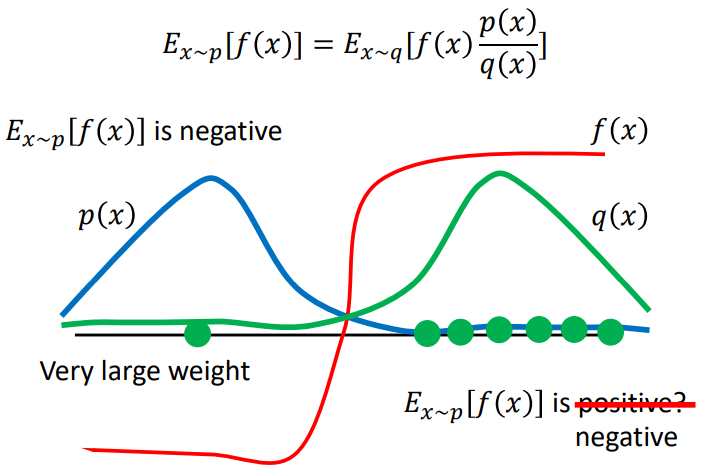
如上图所示，当抽样较少的时候，可能计算出来的近似值符号不一致，只有抽样数量足够多的时候才能避免这种情况，但我们在训练的时候很难确定当前的数据样本数量是否足够。  
  
 ## on-policy $\rightarrow$ off-policy
 原先的参数梯度计算方式：$$\nabla \overline{R}_{\theta} = E_{\tau \sim p_{\theta}(\tau)}[R(\tau)\nabla logp_{\theta}(\tau)]$$
 修改为off-policy计算方式，为：$$\nabla \overline{R}_{\theta} = E_{\tau \sim q_{\theta^{'}}(\tau)}[\frac{p_{\theta}(\tau)}{q_{\theta^{'}}(\tau)}R(\tau)\nabla logp_{\theta}(\tau)]$$  
 利用$\theta^{'}$来抽取数据，并多次利用这些数据来更新参数$\theta$  
 梯度更新过程修改为：  
 $$\begin{equation}
 \begin{aligned}
 E_{(s_t,a_t)\sim \pi_{\theta}}[A^{\theta}(s_t,a_t)\nabla logp_{\theta}(a^n_t|s^n_t)]\\
 &= E_{(s_t,a_t)\sim \pi_{\theta^{'}}}[\frac{P_{\theta}(s_t,a_t)}{P_{\theta^{'}}(s_t,a_t)}A^{\theta^{'}}(s_t,a_t)\nabla logp_{\theta}(a^n_t|s^n_t)]\\
 &=E_{(s_t,a_t)\sim \pi_{\theta^{'}}}[\frac{p_{\theta}(a_t|s_t)}{p_{\theta^{'}}(a_t|s_t)}\frac{p_{\theta}(s_t)}{p_{\theta^{'}}(s_t)}A^{\theta^{'}}(s_t,a_t)\nabla logp_{\theta}(a^n_t|s^n_t)]\\
 &=E_{(s_t,a_t)\sim \pi_{\theta^{'}}}[\frac{p_{\theta}(a_t|s_t)}{p_{\theta^{'}}(a_t|s_t)}A^{\theta^{'}}(s_t,a_t)]
 \end{aligned}
\end{equation} $$
由于在训练过程中，agent的行为并不会影响$p_{\theta}(s_t)$和$p_{\theta^{'}}(s_t)$，因此对于这部分我们忽略不计，因此得到的目标函数为：
$$J^{\theta^{'}}(\theta) = E_{(s_t,a_t)\sim \pi_{\theta^{'}}}[\frac{p_{\theta}(a_t|s_t)}{p_{\theta^{'}}(a_t|s_t)}A^{\theta^{'}}(s_t,a_t)]$$  
  
 ## PPO/TRPO
 在Importance Sampling中我们已经提到了，采用的概率$\theta^{'}$与训练的参数$\theta$两者之间不能相差太多，因此我们在训练的时候需要考虑这两者之间的距离，PPO采用的目标函数为：
 $$J^{\theta^{'}}_{PPO} = J^{\theta^{'}}(\theta) - \beta KL(\theta,\theta^{'})$$  
 在这里$\theta$和$\theta^{'}$直接的KL散度指的是根据state采取的action之间的差距，而不是单纯的参数之间的差距，因此可能有时候参数只有一点点修改，但导致的action采取结果有很大的变化。
 TRPO的训练目标函数为：
 $$J^{\theta^{'}}_{PPO} = J^{\theta^{'}}(\theta)$$
 $$KL(\theta,\theta^{'}) < \delta$$  
 与PPO相比，将这种agent之间的差距作为一个约束条件，但在训练过程中，带约束的训练目标要更难训练，因此此时TRPO要比PPO更难训练。  
 PPO算法的具体流程如下所示：  
 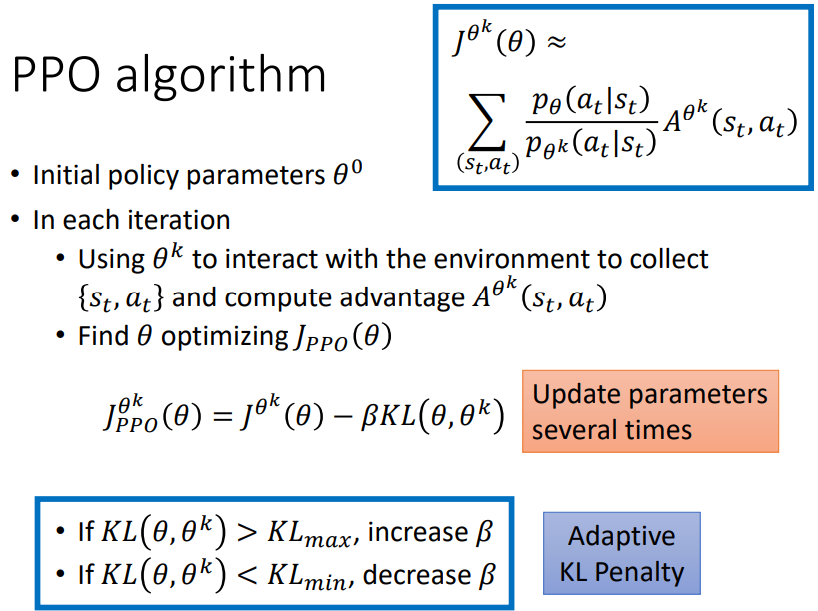
 在原先的PPO算法的基础上，又提出了PPO2算法，该优化目标函数为：
 $$J^{\theta^{k}}_{PPO2} \approx \sum_{(s_t,a_t)} min(\frac{p_{\theta}(a_t|s_t)}{p_{\theta^{k}}(a_t|s_t)}A^{\theta^{k}}(s_t,a_t),\\
 clip(\frac{p_{\theta}(a_t|s_t)}{p_{\theta^{k}}(a_t|s_t)},1-\varepsilon,1+\varepsilon)A^{\theta^{k}}(s_t,a_t))$$  
 当A大于0时，我们希望这个state时采取该action的概率越大越好，因此我们会调整其权重值，希望越大越好，但需要控制两种agent之间的差距，所以要有最大的限制。A小于0时也是同样的思路。
 